In [1]:
import os
import time
import random

import torch
import cv2 as cv
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# import torch.optim as optim
# import torch.nn as nn
# import seaborn as sns


# from torch.utils.data import Dataset, DataLoader
# from torch.cuda import amp
# from tqdm.autonotebook import tqdm, trange
# from torch.optim import lr_scheduler
# from torchvision import datasets, models, transforms

In [2]:
root_dir = ['../data/original']

In [3]:
def get_files_and_labels(list_root_dir):
    images_path = []
    labels = []
    
    list_classes = list(sorted(os.listdir(list_root_dir[0])))
    
    for root_dir in list_root_dir:
        for i, one_class in enumerate(list_classes):
            path_img = list(os.listdir(os.path.join(root_dir, one_class)))
            for path in path_img:
                path_join = os.path.join(root_dir, os.path.join(one_class, path))
                images_path.append(path_join)
                labels.append(i)
    
    df_res = pd.DataFrame()
    df_res['paths'] = images_path
    df_res['labels'] = labels
    
    return df_res


def train_test_split_(df_img_label):
    
    X = np.array(df_img_label['paths'])
    y = np.array(df_img_label['labels'])
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.10, random_state=42)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                        test_size=0.20, random_state=42)
    
    name_columns = ['paths', 'labels']
    train = pd.DataFrame(zip(X_train, y_train), columns=name_columns)
    valid = pd.DataFrame(zip(X_valid, y_valid), columns=name_columns)
    test = pd.DataFrame(zip(X_test, y_test), columns=name_columns)
    
    return train, valid, test


def save_as_csv(train, valid, test):
    save_dir = Path(ROOT, 'data', 'prepared')
    train.to_csv(Path(save_dir, 'train.csv'), index=False)
    valid.to_csv(Path(save_dir, 'valid.csv'), index=False)
    test.to_csv(Path(save_dir, 'test.csv'), index=False)

# Считывание картинок

In [4]:
df_res = get_files_and_labels(root_dir)

In [5]:
df_res

,paths,labels
0,../data/original\esophagitis\001fb927-4814-4ba...,0
1,../data/original\esophagitis\00687a70-bbad-4bf...,0
2,../data/original\esophagitis\0134d93d-0922-406...,0
3,../data/original\esophagitis\01a57b1a-780f-4e5...,0
4,../data/original\esophagitis\01f092a2-fccb-49f...,0
...,...,...
995,../data/original\normal-z-line\fcb8704e-f308-4...,1
996,../data/original\normal-z-line\fdb68e1c-a08b-4...,1
997,../data/original\normal-z-line\fde68ca4-2c9f-4...,1
998,../data/original\normal-z-line\ff257b71-d9b1-4...,1


## Удаление черных краев на картинках

In [6]:
def del_letters(img):
    """
    Удаление букв на картинке.
    Некоторые цифры и буквы могут не удалиться.
    Необходимо выполнить перед удалением черных краев.
    """
#     img_blur = cv.GaussianBlur(img, (5,5),5)
    mask = cv.threshold(img_blur, 210, 255, cv.THRESH_BINARY)[1][:,:,0]
    img_res = cv.inpaint(img_blur, mask, 8, cv.INPAINT_NS)
    
    return img_res

In [7]:
# def del_black_edge_one(src):
#     """
#     Удаляет черные границы на картинке.
    
#     src: считанная картинка при помощи cv.imread()
#     """
#     tmp = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
#     # Applying thresholding technique
#     _, alpha = cv.threshold(tmp, 0, 255, cv.THRESH_BINARY)

#     # Using cv2.split() to split channels 
#     # of coloured image
#     b, g, r = cv.split(src)
   
#     # Making list of Red, Green, Blue
#     # Channels and alpha
#     rgba = [b, g, r, alpha]

#     # Using cv2.merge() to merge rgba
#     # into a coloured/multi-channeled image
#     dst = cv.merge(rgba, 4)
    
#     return dst

def find_mask(img):
    """
    Удаление черных границ по маске.
    """
    # Convert Image to Image HSV
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Defining lower and upper bound HSV values
    lower = np.array([0,0,0])
    upper = np.array([350,20,90])

    # Defining mask for detecting color
    mask = cv.inRange(hsv, lower, upper)

    # invert mask
    mask = cv.bitwise_not(mask)
#     result = cv.cvtColor(img, cv.COLOR_BGR2BGRA)
#     result[:, :, 3] = mask
    
    return mask

In [8]:
def save_img(img, img_path, add_name_img='', name_root_dir = '..\\data_prep\\'):
    """
    Сохранение измененных картинок по оргиналу.
    Сохраняется с тем же названием в другую папку
    """
    
    name_img = img_path.split('\\')[-1].split('.')[0]+ add_name_img + '.jpg'
    name_dir = img_path.split('\\')[-2]

    path = name_root_dir + name_dir + '\\' + name_img
    cv.imwrite(path, img)

In [9]:
def del_area_behind_countour(mask_img):
    mask_img = cv.GaussianBlur(mask_img, (11,11), 10)

    ret, thresh = cv.threshold(mask_img, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    mask = np.zeros(img.shape[0:2], dtype=np.uint8)

    points = sorted(contours, key= lambda c: len(c))[-1]

    #method 1 smooth region
    cv.drawContours(mask, [points], -1, (255, 255, 255), -1, cv.LINE_AA)
    res = cv.bitwise_and(img, img, mask = mask)
    rect = cv.boundingRect(points) # returns (x,y,w,h) of the rect
    cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
    
    return cropped


In [10]:
for i in range(df_res.shape[0]):
    path = df_res['paths'][i]
    img = cv.imread(path, 1)
    img_res = del_area_behind_countour(find_mask(img))
    save_img(img_res, path)

In [11]:
# # проверка на одной картинке
# path = df_res['paths'][10]
# img = cv.imread(path, 1)
# img_res = del_black_edge(del_letters(img))
# save_img(img_res, path)

## Поворот картинок и наложение фильтров

In [12]:
def rotated_image(image, rotation=225):

    # dividing height and width by 2 to get the center of the image
    height, width = image.shape[:2]
    # get the center coordinates of the image to create the 2D rotation matrix
    center = (width/2, height/2)

    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv.getRotationMatrix2D(center=center, angle=rotation, scale=1)

    # rotate the image using cv2.warpAffine
    rotated_image = cv.warpAffine(src=image, M=rotate_matrix, dsize=(width, height))
    
    return rotated_image


In [13]:
def blur_gauss(image):
    return cv.GaussianBlur(image, (11,11), 10)

In [14]:
df_res = get_files_and_labels(['../data_prep/'])

In [15]:
for i in range(df_res.shape[0]):
    path = df_res['paths'][i]
    img = cv.imread(path, 1)
    img_res = blur_gauss(rotated_image(img))
    save_img(img_res, path, '_flip')

In [23]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in C:\Users\89zaz/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [24]:
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [26]:
model_new = torch.nn.Sequential(
    model.encoder1,
    model.pool1,
    model.encoder2,
    model.pool2,
    model.encoder3,
    model.pool3,
    model.encoder4,
    model.pool4,
    model.bottleneck,
    nn.Flatten(),
    nn.Linear(131072, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 2),
    nn.Softmax()
    )

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
model_unet = model_new.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0001)

info = fit(30, model_unet, loss_fn, optimizer,train_dl, valid_dl)


epoch  0


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\89zaz\anaconda3\envs\DeepLearning\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_loss:  0.5869779811799526


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5248114058845922
valid_accuracies:  0.7733333333333333
epoch  1


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5522176760435105


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5221189291853654
valid_accuracies:  0.78
epoch  2


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5364097845554352


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5249511536798979
valid_accuracies:  0.78
epoch  3


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.527470797598362


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.50721485991227
valid_accuracies:  0.8066666666666666
epoch  4


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5132017597556114


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5025177354875364
valid_accuracies:  0.8133333333333334
epoch  5


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5148953837156296


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5188025330242357
valid_accuracies:  0.78
epoch  6


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5084438681602478


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.511833078767124
valid_accuracies:  0.8066666666666666
epoch  7


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.48141288340091704


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5008300660472167
valid_accuracies:  0.82
epoch  8


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4742836967110634


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5134672122566324
valid_accuracies:  0.7866666666666666
epoch  9


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.47680570408701894


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4999606413276572
valid_accuracies:  0.8
epoch  10


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.47824313595891


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5160990326028121
valid_accuracies:  0.8066666666666666
epoch  11


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.46222842678427695


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4980978228543934
valid_accuracies:  0.8066666666666666
epoch  12


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4475976696610451


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5050457778729891
valid_accuracies:  0.7933333333333333
epoch  13


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4371379590034485


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.513103292176598
valid_accuracies:  0.78
epoch  14


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.44819401353597643


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5070671486227136
valid_accuracies:  0.8133333333333334
epoch  15


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.42419608354568483


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.49441152497341756
valid_accuracies:  0.8133333333333334
epoch  16


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.41701694816350937


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5083508467987964
valid_accuracies:  0.8133333333333334
epoch  17


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.43732799485325813


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5274148559884021
valid_accuracies:  0.7666666666666667
epoch  18


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4288038970530033


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5100219281096208
valid_accuracies:  0.8
epoch  19


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4032937388122082


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5010518212067453
valid_accuracies:  0.8066666666666666
epoch  20


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4145419079065323


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5145491612584967
valid_accuracies:  0.7933333333333333
epoch  21


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.41306395933032036


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4907667142780204
valid_accuracies:  0.8266666666666667
epoch  22


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.40281215518713


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.49343329824899373
valid_accuracies:  0.8333333333333334
epoch  23


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4179641759395599


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.49706241488456726
valid_accuracies:  0.8066666666666666
epoch  24


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.39784340739250185


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4977854545179166
valid_accuracies:  0.8066666666666666
epoch  25


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.3925293458998203


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.48958710149714824
valid_accuracies:  0.8333333333333334
epoch  26


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.3887221696972847


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4907742181890889
valid_accuracies:  0.8133333333333334
epoch  27


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.3905408285558224


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4943234575422187
valid_accuracies:  0.8133333333333334
epoch  28


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.39790559202432635


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4953861079717937
valid_accuracies:  0.8
epoch  29


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.39507890105247495


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.4957388592393775
valid_accuracies:  0.8266666666666667


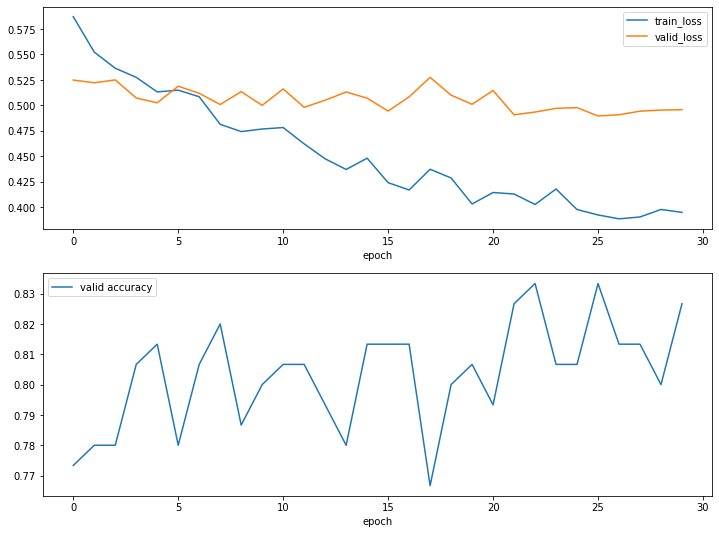

In [13]:
plot_training(*info)

In [27]:
model_unet = model_new.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0001)

info_1 = fit(30, model_unet, loss_fn, optimizer,train_dl, valid_dl)


epoch  0


  0%|          | 0/200 [00:00<?, ?it/s]

C:\Users\89zaz\anaconda3\envs\DeepLearning\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_loss:  0.6030819799005985


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5641883768533406
valid_accuracies:  0.7266666666666667
epoch  1


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5517732611298561


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5293548962003306
valid_accuracies:  0.8066666666666666
epoch  2


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5377113412320614


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5236805300963553
valid_accuracies:  0.7733333333333333
epoch  3


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5276544234156608


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5234702111859071
valid_accuracies:  0.78
epoch  4


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.5087884570658207


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5230753711963955
valid_accuracies:  0.7933333333333333
epoch  5


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.48797212794423106


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5315846338083869
valid_accuracies:  0.7933333333333333
epoch  6


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4895181632041931


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5286789952140105
valid_accuracies:  0.7666666666666667
epoch  7


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.49298402726650237


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.522511969271459
valid_accuracies:  0.7666666666666667
epoch  8


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.47883900105953214


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5278876690488112
valid_accuracies:  0.76
epoch  9


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4800195367634296


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5265888085490779
valid_accuracies:  0.78
epoch  10


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4764439435303211


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5179340627632643
valid_accuracies:  0.7666666666666667
epoch  11


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.45086383566260335


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5348621144106513
valid_accuracies:  0.7466666666666667
epoch  12


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.44860291048884393


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5275399386882782
valid_accuracies:  0.76
epoch  13


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4364143963158131


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5238642786678515
valid_accuracies:  0.7733333333333333
epoch  14


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.44719370409846304


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5068901424345217
valid_accuracies:  0.8066666666666666
epoch  15


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4497325104475021


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.519330612138698
valid_accuracies:  0.78
epoch  16


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4370645149052143


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5122426669848593
valid_accuracies:  0.7733333333333333
epoch  17


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.41989532977342603


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5157465166167209
valid_accuracies:  0.7666666666666667
epoch  18


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4352248224616051


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5286503677305422
valid_accuracies:  0.7733333333333333
epoch  19


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.41993787586688996


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5374319396520916
valid_accuracies:  0.7466666666666667
epoch  20


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.41478998512029647


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5348928358994032
valid_accuracies:  0.7666666666666667
epoch  21


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4237675975263119


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5280693110666776
valid_accuracies:  0.76
epoch  22


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.42265655934810636


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5266974780120348
valid_accuracies:  0.7866666666666666
epoch  23


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.40034452348947525


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5203271618014887
valid_accuracies:  0.7866666666666666
epoch  24


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.4078391748666763


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.51717593403239
valid_accuracies:  0.8
epoch  25


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.40803624257445337


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5578700311874089
valid_accuracies:  0.7
epoch  26


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.38899379312992094


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5210113337165431
valid_accuracies:  0.7733333333333333
epoch  27


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.3906680406630039


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5210168432248267
valid_accuracies:  0.7733333333333333
epoch  28


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.39288302570581435


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5290123388955468
valid_accuracies:  0.7666666666666667
epoch  29


  0%|          | 0/200 [00:00<?, ?it/s]

train_loss:  0.3951776868104935


  0%|          | 0/38 [00:00<?, ?it/s]

val_loss:  0.5329766202914087
valid_accuracies:  0.74


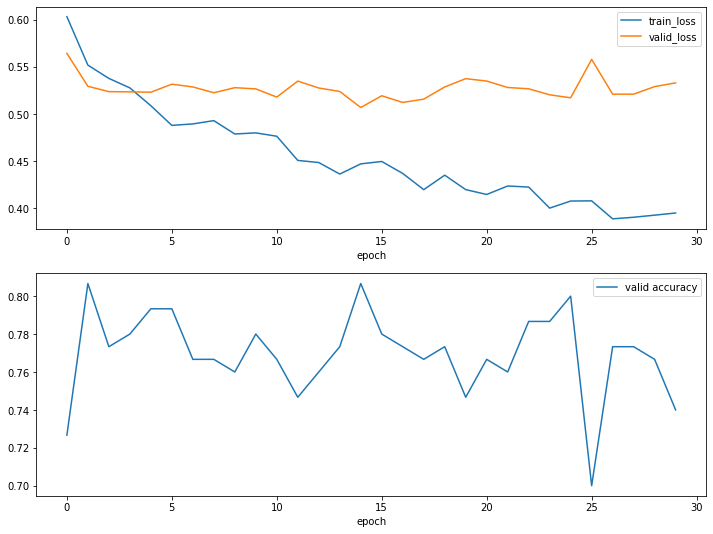

In [28]:
plot_training(*info_1)